In [40]:
# INTRO:
# 1- Loaded into astroimageJ the 16/11/2021 "B transit raw data"
# 2- Model the transit with astroimageJ 
# 3- Residuals from raw data minus transit model apperars in astroimageJ column "rel_flux_T1_fn_residual" 
# 4- Filtered out frequencies higher than 400 d^(-1) (--> Periods shorter than few minutes)
# 5- Loaded filtered signal in Period04
# 6- Finding Frequencies, Amplitudes and Phases with Period04
# 7- Some of the frequencies, amplitudes and phases found with Period04
#    are used to generate the synthetic pulsation signal

In [41]:
import json
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

In [42]:
# Filenames and Constants to be updated as needed

transit_B_fn = "../data/data_mros/20220205_TransB_C3asRef.csv"
fs = 1920 # 1 sample point each 45s --> 1/45s *60s/min * 60min/1h * 24h/día --> 0.022222*60*60*24 = 1920 d^(-1)
cutoff = 400 #c/d (cycles/day --> d^(-1))
order = 3

In [43]:
transit_B_df = pd.read_csv(transit_B_fn, sep=" ")
transit_B_df

,Unnamed: 0,n,num,Label,slice,J.D.-2400000,JD_UTC,Source_Radius,Sky_Rad(min),Sky_Rad(max),...,Mean_T4,Sky/Pixel_T4,Width_T4,X-Width_T4,Y-Width_T4,Angle_T4,Roundness_T4,rel_flux_T1_model,rel_flux_T1_model_residual,filtered_pulsations
0,0,0,1,WASP-33-0001B_norm.fit,1,59535.434024,2.459535e+06,60,80,100,...,12.639972,9.746982,39.658676,44.087403,35.229949,11.778136,0.942090,3.519899,0.008141,0.007994
1,1,1,2,WASP-33-0002B_norm.fit,2,59535.434822,2.459535e+06,60,80,100,...,13.626745,10.778810,48.949668,64.412890,33.486445,4.974360,0.659828,3.519899,0.012005,0.005643
2,2,2,3,WASP-33-0003B_norm.fit,3,59535.435612,2.459535e+06,60,80,100,...,13.395058,10.594457,42.681981,55.616103,29.747859,351.414334,0.662448,3.519899,0.010880,0.003419
3,3,3,4,WASP-33-0004B_norm.fit,4,59535.436400,2.459535e+06,60,80,100,...,12.488979,9.077924,45.044711,50.732125,39.357296,4.248335,0.936839,3.519899,-0.010100,0.001426
4,4,4,5,WASP-33-0005B_norm.fit,5,59535.437186,2.459535e+06,60,80,100,...,12.402453,9.548546,51.419047,68.379604,34.458490,354.315264,0.631702,3.519899,0.006939,-0.000199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,255,255,256,WASP-33-0256B_norm.fit,256,59535.636000,2.459536e+06,60,80,100,...,17.372959,14.752823,46.201013,48.278277,44.123749,35.060740,0.930344,3.519899,-0.004657,0.007521
256,256,256,257,WASP-33-0257B_norm.fit,257,59535.636795,2.459536e+06,60,80,100,...,17.112929,14.521637,53.688694,65.016257,42.361131,18.361740,0.745963,3.519899,0.002978,0.006706
257,257,257,258,WASP-33-0258B_norm.fit,258,59535.637592,2.459536e+06,60,80,100,...,16.979454,14.479620,56.142373,73.013686,39.271059,5.253918,0.685682,3.519899,0.015919,0.005241
258,258,258,259,WASP-33-0259B_norm.fit,259,59535.638390,2.459536e+06,60,80,100,...,16.468974,13.896864,54.449543,62.212236,46.686850,24.025468,0.825235,3.519899,0.017630,0.003216


In [44]:
# Get the Pulsations Signal on 16/11/2021 from the observations of Pulsations+Signal
pulsationsB = np.array(transit_B_df["rel_flux_T1_model_residual"])
transit_B_df["pulsationsB"] = pulsationsB

<AxesSubplot:xlabel='J.D.-2400000'>

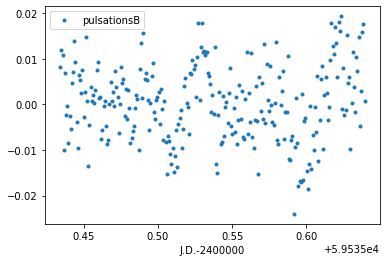

In [45]:
transit_B_df.plot(x="J.D.-2400000", y="pulsationsB", marker='.', linestyle='none')

<AxesSubplot:xlabel='J.D.-2400000'>

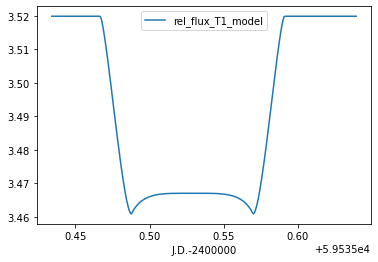

In [46]:
transit_B_df.plot(x="J.D.-2400000", y="rel_flux_T1_model")

4.92

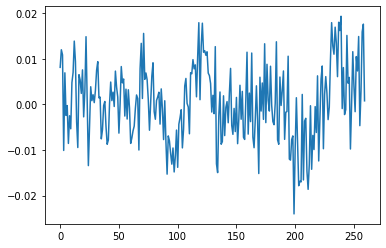

In [47]:
plt.plot(pulsationsB)

ti = transit_B_df["J.D.-2400000"][0]
tf = transit_B_df["J.D.-2400000"][len(pulsationsB)-1]

duration = tf - ti

# Durantion of the data acquisition in hours
duration_hours =  round(duration * 24, 2)
duration_hours

In [48]:
def butterworth_lowpass(data, fs, cutoff, order):
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return np.array(y)

In [49]:
filtered_pulsations = butterworth_lowpass(pulsationsB, fs, cutoff, order)

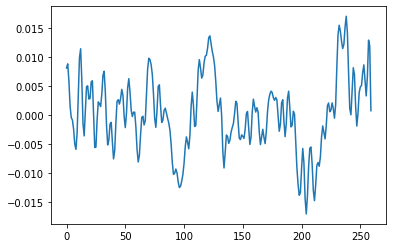

In [50]:
plt.plot(filtered_pulsations)
transit_B_df["filtered_pulsations"] = filtered_pulsations

In [51]:
def test_func(t, A1, w1, ph1, A2, w2, ph2, A3, w3, ph3):
    return (A1 * np.sin(w1*t + ph1) 
            + A2 + np.sin(w2*t + ph2) 
            + A3 + np.sin(w3*t + ph3))
                           
A1 = 0.4
f1 = 20   #20.16263 # Units: [d^(-1)]
w1 = 2*np.pi*f1
ph1 = 0.4904

A2 = 0.2
f2 = 10
w2 = 2*np.pi*f2
ph2 = 0.741884

A3 = 0.26
f3 = 10
w3 = 2*np.pi*f3
ph3 = 0.529183

param, _ = optimize.curve_fit(
    test_func, 
    transit_B_df["J.D.-2400000"], filtered_pulsations, #transit_B_df["rel_flux_T1_fn_residual"], 
    p0=[A1, w1, ph1, A2, w2, ph2, A3, w3, ph3])
                           
t = transit_B_df["J.D.-2400000"]

(A1, w1, ph1) = (param[0], param[1], param[2])
(A2, w2, ph2) = (param[3], param[4], param[5])
(A3, w3, ph3) = (param[6], param[7], param[6])

fitted_pulsations = (A1 * np.sin(w1*t + ph1) + 
                     A2 * np.sin(w2*t + ph2) + 
                     A3 * np.sin(w3*t + ph3))

transit_B_df["no_fitted_pulsations"] = fitted_pulsations                 

In [52]:
transit_B_df.to_csv(path_or_buf="/home/mrosanes/Desktop/ASTRO/Practiques-OSN/data_analysis/data/data_mros/filtered_pulsations_from_transit_B.csv", sep="\t")

In [53]:

def generate_signal_from_sins(times, sins):
    """
    Generate signal from a list of sinus, each of them 
    containing frequency, amplitude and phase
    """
    t = np.array(times)
    generated_pulsations = np.zeros((len(t)), dtype=np.float32)
    for sin in sins:
        f = sin[0]    
        A = sin[1]
        ph = sin[2]
        generated_pulsations = generated_pulsations + A * np.sin(2*np.pi*(f*t + ph))
    generated_pulsations = (-1)*generated_pulsations
    return generated_pulsations

In [54]:
#Frequencies f: Units:[d^(-1)]  # f1 = 20.16263 [C. von Essen, M. Mallonn et al. 22 April 2020]

# sins: [[f, A, phase]]
sins = [[21.934, 0.024073, 0.424187], 
        [11.21, 0.0182, 0.43843],
        [33.388, 0.01296, 0.71237],
        [41.674, 0.01003, 0.03148],
        [68.7255, 0.007956, 0.5562],
        [7.3112, 0.00929, 0.85739],
        [16.0847, 0.006355, 0.84097],
        [27.5389, 0.005795, 0.542038],
        [85.7850, 0.0054743, 0.29795],
        [48.2541, 0.00518, 0.7894]]

times = np.array(transit_B_df["J.D.-2400000"])
generated_pulsations = generate_signal_from_sins(times, sins)

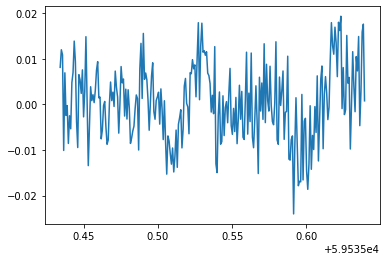

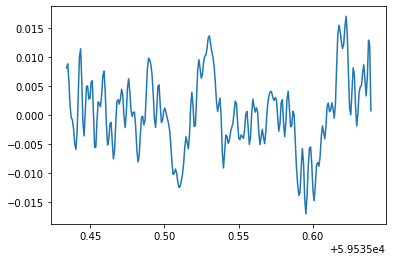

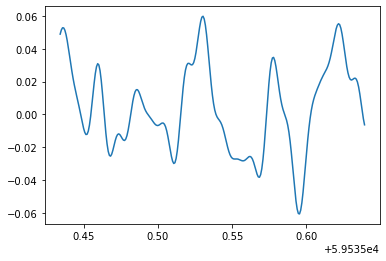

In [55]:
plt.figure(); plt.plot(times, pulsationsB)
plt.figure(); plt.plot(times, filtered_pulsations)
plt.figure(); plt.plot(times, generated_pulsations)

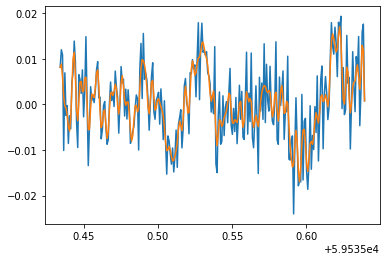

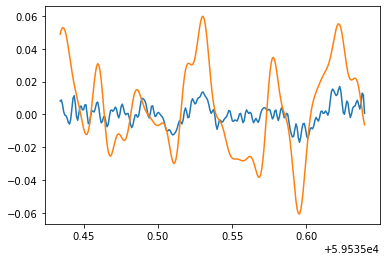

In [56]:
plt.figure(); plt.plot(times, pulsationsB); plt.plot(times, filtered_pulsations)
plt.figure(); plt.plot(times, filtered_pulsations); plt.plot(times, generated_pulsations)

In [57]:
puls_data_fn = "../data/data_ciro/Puls/Measurements_Pulsacion_WASP33_I_space.csv"

In [58]:
pulse_I_df = pd.read_csv(puls_data_fn, sep=" ")

<AxesSubplot:xlabel='J.D.-2400000'>

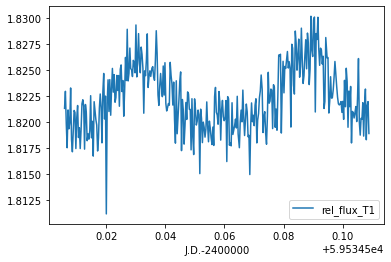

In [59]:
pulse_I_df.plot(x="J.D.-2400000", y="rel_flux_T1")

In [60]:
sins = [[18.94307,0.00287,0.187532], [35.45755,0.00109,0.741884], [9.7144,0.00076,0.529183]]
times = np.array(pulse_I_df["J.D.-2400000"])
generated_pulsations = generate_signal_from_sins(times, sins)

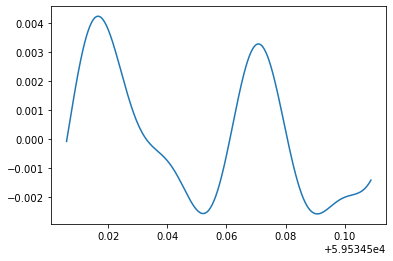

In [61]:
plt.plot(times, generated_pulsations)

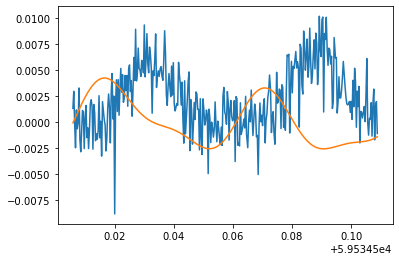

In [62]:
rel_flux_T1 = np.array(pulse_I_df["rel_flux_T1"])
plt.figure(); plt.plot(times, rel_flux_T1-1.82); plt.plot(times, generated_pulsations)